# Movie Recommender System, part II: Training Wide-Deep Model
### Robert Chen, B20-AI
-----------------------------------------

## Step 0: Imports

We need to add `src` directory to `PATH` in order to work with relative packages. There will be a cell with the deletion of this directory from `PATH` if needed.

In [1]:
import sys
from pathlib import Path
src_path = str(Path('..').resolve())
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import math
import itertools
import numpy as np
import pandas as pd
import scrapbook as sb
import sklearn.preprocessing
from tempfile import TemporaryDirectory
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
from recommenders.utils.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    DEFAULT_GENRE_COL as ITEM_FEAT_COL,
    SEED
)
from recommenders.utils import tf_utils, gpu_utils, plot
from recommenders.datasets.pandas_df_utils import user_item_pairs
from recommenders.datasets.python_splitters import python_random_split
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep
from src.utils.data import load_movielens

In [3]:
# Parameters 

# Recommend top k items
TOP_K = 10
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = "100k"
# Metrics to use for evaluation
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.precision_at_k.__name__,
]
RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]
# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True

RANDOM_SEED = SEED  # Set seed for deterministic result

EXPORT_DIR_BASE = os.path.join("outputs", "model")
# Model checkpoints directory. If None, use temp-dir.
MODEL_DIR = str(Path(os.path.join('..', 'models', 'wide_deep')).resolve())

#### Hyperparameters
MODEL_TYPE = "wide_deep"
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32
# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = "adagrad"
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# DNN model hyperparameters
DNN_OPTIMIZER = "adadelta"
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1     

## Step 1: Loading the MovieLens Dataset

 [Recommenders Team](https://github.com/recommenders-team) (Microsoft Recommenders in the past) presented the [Recommenders](https://github.com/recommenders-team/recommenders) GitHub repository with the best practices on recommendation systems. Most of the work will be heavily based on the concepts described in this repo. For now, we will use their method to parse the dataset to obtain a neat `DataFrame` fast and easy:

In [4]:
movielens_df = load_movielens('100k')
movielens_df.head()

100%|██████████| 4.81k/4.81k [00:01<00:00, 2.42kKB/s]


,userID,itemID,rating,genre
0,196,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,63,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,226,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,154,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,306,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Now, we need to split the dataset into the *train* and *test* parts:

In [5]:
train, test = python_random_split(movielens_df, ratio=0.75, seed=RANDOM_SEED)
print(f'train: {len(train)} samples, test: {len(test)} samples')

train: 75000 samples, test: 25000 samples


Also, it would be useful to infer unique users and items:

In [6]:
# Unique itmes in the dataset
items = movielens_df.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
item_feat_shape = len(items[ITEM_FEAT_COL][0])
# Unique users in the dataset
users = movielens_df.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)
print(f'Unique items: {len(items)} | Unique users: {len(users)}')

Unique items: 1682 | Unique users: 943


## Step 2: Wide & Deep Model

The majority of current recommendation models are based either on [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) (example: [Simple Algorithm for Recommendation (SAR)](https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/sar_movielens.ipynb)) or [content-based filtering](https://developers.google.com/machine-learning/recommendation/content-based/basics#:~:text=Content%2Dbased%20filtering%20uses%20item,previous%20actions%20or%20explicit%20feedback.) (example: [TF-IDF](https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/tfidf_covid.ipynb)). 


[Wide & Deep model](https://arxiv.org/abs/1606.07792), however, is a hybrid model. 

The model bases on a following logic &mdash; a *linear model* with a wide set of features is able to memorize the feature interactions through co-occurence, while
*deep neural networks (DNN)* have the ability to generalize the feature patterns using dense low-dimensional embeddings inferred from sparse features. By combining **wide linear models** and **deep neural networks** through joint training, benefits from the memorization and generalization capabilities of the model can be used to create an effective model for recommender systems.

## Step 4: Implementation

Original implementation of the model by Recommenders Team ([link](https://github.com/recommenders-team/recommenders/blob/main/recommenders/models/wide_deep/wide_deep_utils.py)) is a simple wrapper on [`tf.estimator.DNNLinearCombinedRegressor`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNLinearCombinedRegressor). Also, it can be used to create wide-only and deep-only models, but we are not interested in them.
The implementation step consists of 4 phases:
- Data Preparation
- Model Build
- Training and Evaluation
- Testing

### Data Preparation

First, we need to build the **wide** and **deep** feature columns that will be used by a model:

In [7]:
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users[USER_COL].values,
    items=items[ITEM_COL].values,
    user_col=USER_COL,
    item_col=ITEM_COL,
    item_feat_col=ITEM_FEAT_COL,
    crossed_feat_dim=1000,
    user_dim=DNN_USER_DIM,
    item_dim=DNN_ITEM_DIM,
    item_feat_shape=item_feat_shape,
    model_type=MODEL_TYPE,
)

print("Wide feature specs:")
for c in wide_columns:
    print("* ", str(c)[:100], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("* ", str(c)[:100], "...")

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use `tf.keras.layers.experimental.preprocessing.HashedCrossing` instead for feature crossing when preprocessing data to train a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Wide feature specs:
*  Vocabula

### Model Build

The hyperparameters used can be tweeked in above in order to see how the training process will change

In [8]:
# Create model checkpoint every n steps. We store the model 5 times.
save_checkpoints_steps = max(1, STEPS // 5)
# Build a model based on the parameters
model = wide_deep.build_model(
    model_dir=MODEL_DIR,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG,
        'l2_regularization_strength': LINEAR_L2_REG,
        'momentum': LINEAR_MOMENTUM,
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG,
        'l2_regularization_strength': DNN_L2_REG,
        'momentum': DNN_MOMENTUM,  
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS,
    dnn_dropout=DNN_DROPOUT,
    dnn_batch_norm=(DNN_BATCH_NORM==1),
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED
)

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Using config: {'_model_dir': '/home/b0b/Personal/Uni/InnoStuff/F23/Practical Machine Learning/Recommender System/models/wide_deep', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0

## Training & Evaluation

First, we need to create a ranking evaluation set and remove all seen items:

In [9]:
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}

# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
ranking_pool = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    user_item_filter_df=train,  # Remove seen items
    shuffle=True,
    seed=RANDOM_SEED
)

Now, we need to define the training function and training hooks (in case we need to track training statistic):

In [10]:
# Define training hooks to track performance while training
hooks = []
if EVALUATE_WHILE_TRAINING:
    evaluation_logger = tf_utils.MetricsLogger()
    for metrics in (RANKING_METRICS, RATING_METRICS):
        if len(metrics) > 0:
            hooks.append(
                tf_utils.evaluation_log_hook(
                    model,
                    logger=evaluation_logger,
                    true_df=test,
                    y_col=RATING_COL,
                    eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
                    every_n_iter=save_checkpoints_steps,
                    model_dir=MODEL_DIR,
                    eval_fns=[evaluator.metrics[m] for m in metrics],
                    **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
                )
            )

# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

Train loop:

In [11]:
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Training steps = 50000, Batch size = 32 (num epochs = 21)
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling c

Plots for `NDCG at k`, `Precision at k`, `RMSE` and `MAE` (lower is better):

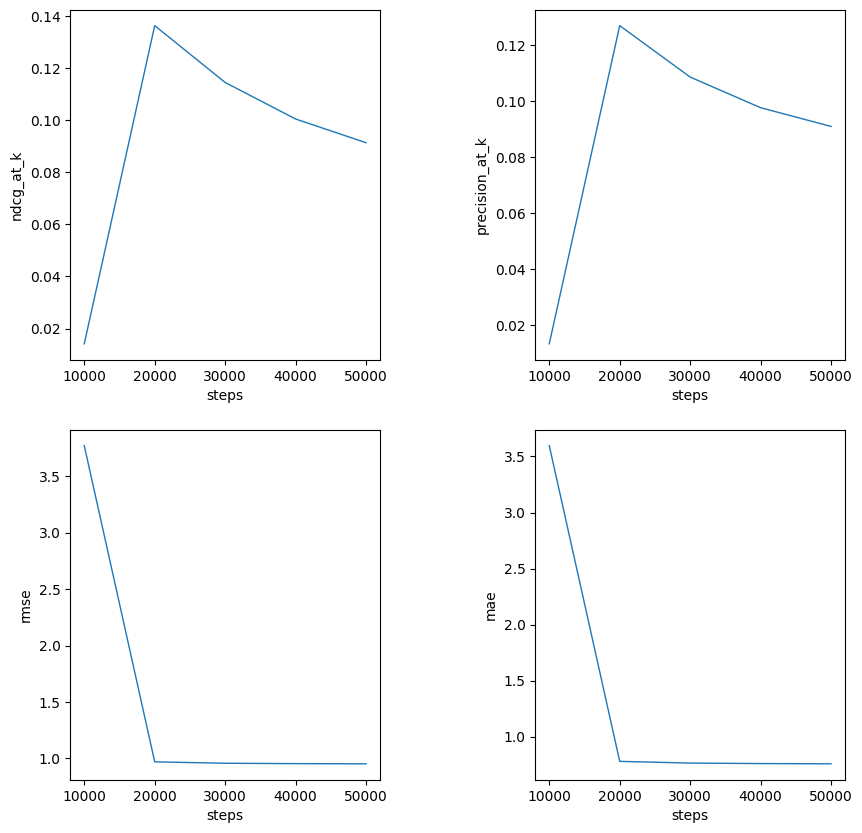

In [12]:
if EVALUATE_WHILE_TRAINING:
    logs = evaluation_logger.get_log()
    for i, (m, v) in enumerate(logs.items(), 1):
        sb.glue("eval_{}".format(m), v)
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(
            values=list(zip(v, x)),
            labels=m,
            x_name="steps",
            y_name=m,
            subplot=(math.ceil(len(logs)/2), 2, i),
        )

### Testing

Now we can evaluate the test set at Top-K recommendations with `k = 10`. If there is a need to test another `k`, `TOP_K` constant can be changed in the cell above:

In [13]:
if len(RANKING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
    prediction_df = ranking_pool.copy()
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

    ranking_results = {}
    for m in RANKING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **{**cols, 'k': TOP_K})
        sb.glue(m, result)
        ranking_results[m] = result


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/b0b/Personal/Uni/InnoStuff/F23/Practical Machine Learning/Recommender System/models/wide_deep/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'ndcg_at_k': 0.08590537374837078, 'precision_at_k': 0.08568398727465537}          userID  itemID                                              genre  \
0           626    1422  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...   
1           818     219  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...   
2            75    1639  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
3           352    1491  [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
4            68    1639  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
...         ...     ...                                                ...   
1511121     179     811  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1511122     225    1395  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
1511123     866    1054  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1511124     665     916  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   
1511125     473     636  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
if len(RATING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
    prediction_df = test.drop(RATING_COL, axis=1)
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    rating_results = {}
    for m in RATING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **cols)
        sb.glue(m, result)
        rating_results[m] = result
    print(rating_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/b0b/Personal/Uni/InnoStuff/F23/Practical Machine Learning/Recommender System/models/wide_deep/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'rmse': 0.9526168120439019, 'mae': 0.7576622662758827}


In [21]:
prediction_df.head()

,userID,itemID,genre,prediction
75721,498,693,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",3.219153
80184,642,542,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",2.861209
19864,58,135,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...",3.849336
76699,495,674,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",3.376119
92991,618,735,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",3.499099


## Step 5: Clean-up

In [14]:
if src_path in sys.path:
    sys.path.remove(src_path)

More clean, unified implementation can be found in `src/models/wide_deep` folder.